# 1  Mod 4 Project: Natural Language Processing (NLP) -  Working Copy

### Improving online conversation: Use of NLP analysis to build a multi-headed model capable of detecting different types of online discussion toxicity like threats, obscenity, insults, and identity-based hate.



   Student name: Andi Osika  
 * Student pace: part time
 * Scheduled project review date/time: TBD
 * Instructor name: James Irving, PhD
 * Blog post URL: 

## Project Quick Links:
**Link** | **Description**
--| --|
[Background](#Background:) | Details around the subject, datasource and objective
[Preprocessing](#Preprocessing:) | Steps taken to prepare data for modeling and evaluation
[Main Dataset](#Main-Dataset:) | The dataset in it's final form used for the predictive modeling results described in the [Conclusion](#Conclusion:)  section
[Modeling](#Modeling:) | Various iterations of predictive classification modeling including Decision Trees, Random Forest and XGBoost
[Best Model](#BEST-MODEL:-Manually-Tuned-Random-Forest) |Random Forest Classification Model including [Visualizations]() Confusion Matrix, ROC Curve, Feature Importance by Rank, Correlations
    [Conclusion](#Conclusion:) | Summation of outcomes from modeling

## Background:

Freedom of speech is a right.  Digital platforms facilitate conversations but struggle to efficiently do so in a way that facilitates this freedom in a way that minimizes the threat of online abuse and harrasment that can come with the 'anonymity effect' of a virtual climate.   

This dataset is provided by [Conversation AI ](https://conversationai.github.io/) is a collaborative research effort exploring ML as a tool for better discussions online.  The source is a dataset of comments from Wikipedia’s talk page edits. 

A classification list of 159,571 samples is provided of Wikipedia comments which have been labeled by human raters for toxic behavior. 

>The types of toxicity are:
* toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

## Preprocessing:

### Importing the appropriate packages:

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import functions as fn
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

2020-06-09 20:07:58.146389-07:00
[i] Timer started at06/09/20 - 08:07 PM
[i] Timer ended at 06/09/20 - 08:07 PM
- Total time = 0:00:00


### Data Import: Trainging and Testing DataSets

#### Test

In [2]:
test = pd.read_csv('test.csv', index_col='id')
test.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [3]:
X_test = test['comment_text']

In [4]:
y_test = pd.read_csv('test_labels.csv', index_col='id')


In [5]:
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [6]:
y_test = y_test[y_test.sum(axis=1)!=-6]
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
0001ea8717f6de06,0,0,0,0,0,0
000247e83dcc1211,0,0,0,0,0,0
0002f87b16116a7f,0,0,0,0,0,0
0003e1cccfd5a40a,0,0,0,0,0,0
00059ace3e3e9a53,0,0,0,0,0,0


In [7]:
val_counts_test = y_test.apply(pd.Series.value_counts)
val_counts_test

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,57888,63611,60287,63767,60551,63266
1,6090,367,3691,211,3427,712


In [8]:

val_counts_test.head(2).plot(kind='bar',figsize=(10,8))

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/55975

#### Train

In [9]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
X = train['comment_text']

In [11]:
target_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[target_classes]

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
val_counts = y_train.apply(pd.Series.value_counts)
val_counts

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,108235,118494,113318,119322,113760,118613
1,11443,1184,6360,356,5918,1065


In [15]:
y_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,119678.000000,119678.000000,119678.000000,119678.000000,119678.000000,119678.000000
mean,0.095615,0.009893,0.053143,0.002975,0.049449,0.008899
std,0.294064,0.098972,0.224319,0.054459,0.216805,0.093914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# check for any 'null' comment
no_comment = X_train.isnull().value_counts()
len(no_comment)

1

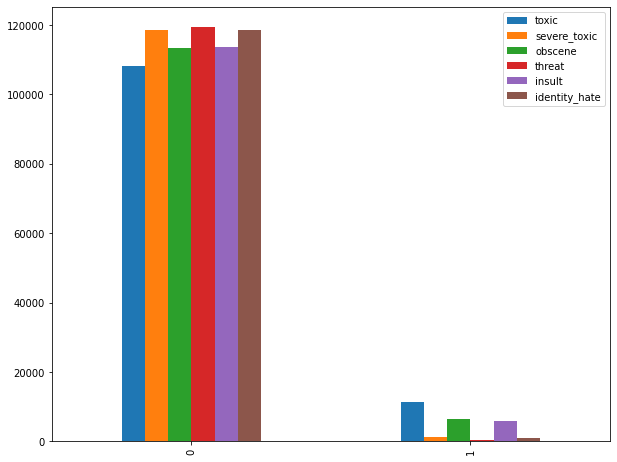

In [17]:
val_counts = y_train.apply(pd.Series.value_counts)
val_counts.head(2).plot(kind='bar',figsize=(10,8))

In [18]:
##develop the viz above to illustrate

In [19]:
value_counts_train = round(val_counts.head(2).T)
value_counts_train

,0,1
toxic,108235,11443
severe_toxic,118494,1184
obscene,113318,6360
threat,119322,356
insult,113760,5918
identity_hate,118613,1065


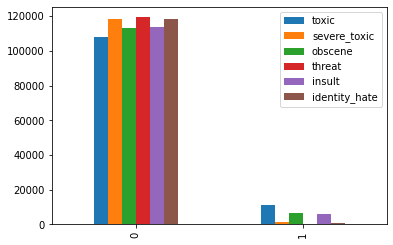

In [20]:
value_counts_train.T.plot(kind='bar')

In [21]:
unlabelled_in_all = y_train[(y_train['toxic']!=1) & (y_train['severe_toxic']!=1) & (y_train['obscene']!=1) & 
                            (y_train['threat']!=1) & (y_train['insult']!=1) & (y_train['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', round(len(unlabelled_in_all)/len(train)*100))

Percentage of unlabelled comments is  67


In [22]:
#Total rows in train
print('Total rows in X_train is {}'.format(len(X_train)))

Total rows in X_train is 119678


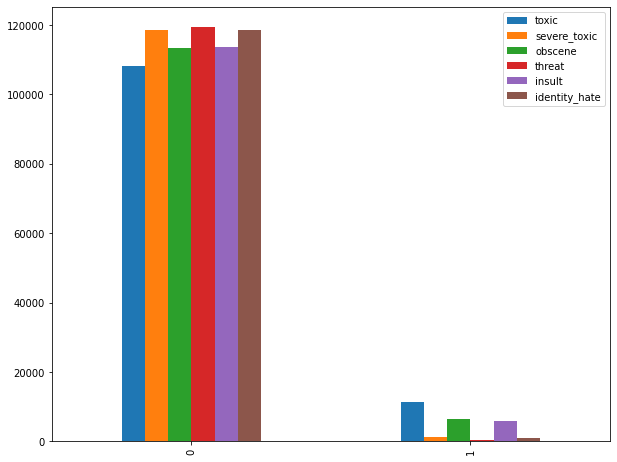

In [23]:
val_counts.head(2).plot(kind='bar',figsize=(10,8))

In [24]:
y_train[y_train[target_classes].sum(axis=1)>0]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
158836,1,0,0,0,0,0
6533,1,1,1,0,1,0
36191,1,1,1,0,1,0
111499,1,0,0,0,0,0
44749,1,0,0,0,0,0
...,...,...,...,...,...,...
88807,1,0,0,0,1,0
127125,1,1,1,0,1,0
102141,1,0,1,0,1,0
51169,1,0,1,0,1,0


You can see here that some labels can be assigned to more than one class

#### The Text Data:

An initial look will examine frequency distributions

In [25]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

# It is generally a good idea to also remove punctuation

# Now we have a list that includes all english stopwords, as well as all punctuation
stopwords_list += list(string.punctuation)

In [26]:
text = str(list(X_train))

### Tokenizing initial set of text corpus to develop stopword list:
(Takes 2 Min)

In [27]:
timer = fn.Timer()

timer.start()
tokens = word_tokenize(text)
timer.stop()

[i] Timer started at06/09/20 - 08:08 PM
[i] Timer ended at 06/09/20 - 08:10 PM
- Total time = 0:01:55.034654


In [28]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

#remove punctuation
stopwords_list += list(string.punctuation)
##adding adhoc all strings that don't appear to contribute, added 'article, page and wikipedia' iteratively as 
##these are parts of most comment strings
stopwords_list += ("''","``", "'s", "\\n\\n" , '...', 'i\\','\\n',
                   '•', "i", 'the', "'m", 'i\\', "'ve", "don\\'t",
                  "'re", "\\n\\ni", "it\\", "'ll", 'you\\', "'d", "n't",
                  '’', 'article', 'page', 'wikipedia') 
                   

In [29]:
timer = fn.Timer()
timer.start()
stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopwords_list]
timer.stop()

[i] Timer started at06/09/20 - 08:10 PM
[i] Timer ended at 06/09/20 - 08:10 PM
- Total time = 0:00:26.638027


In [30]:
len(stopped_tokens)

4122938

In [31]:
from nltk import FreqDist
freqdist = FreqDist(stopped_tokens)
most_common_stopped = freqdist.most_common(200)
most_common_stopped

[('talk', 25481),
 ('would', 22389),
 ('like', 21085),
 ('one', 20700),
 ('please', 18768),
 ('see', 15632),
 ('think', 14897),
 ('also', 14448),
 ('know', 14158),
 ('people', 13476),
 ('edit', 13125),
 ('use', 11971),
 ('articles', 11906),
 ('may', 11534),
 ('time', 11304),
 ('even', 9922),
 ('get', 9887),
 ('make', 9728),
 ('good', 9152),
 ('user', 9028),
 ('information', 8964),
 ('could', 8961),
 ('want', 8608),
 ('way', 8354),
 ('sources', 8034),
 ('deletion', 7928),
 ('name', 7902),
 ('first', 7773),
 ('wp', 7643),
 ('new', 7623),
 ('say', 7611),
 ('need', 7565),
 ('well', 7561),
 ('editing', 7521),
 ('source', 7509),
 ('pages', 7378),
 ('section', 7367),
 ('help', 7356),
 ('edits', 7355),
 ('go', 7277),
 ('image', 7250),
 ('thanks', 7202),
 ('made', 7162),
 ('much', 7050),
 ('many', 6976),
 ('used', 6891),
 ('really', 6839),
 ('find', 6720),
 ('discussion', 6618),
 ('fuck', 6508),
 ('work', 6468),
 ('deleted', 6410),
 ('point', 6254),
 ('add', 6149),
 ('since', 6037),
 ('right', 

In [32]:
# model = Word2Vec(text, size=100, window=5, min_count=1, workers=4)

In [33]:
X_train.head()

72819     "\n\n""Hindutva"" as defined by Savarkar bague...
113825    This merger tag should be removed since it has...
90608     "\n\n GA bot and unusual characters \n\nGA bot...
149717    they are not users but vandals! and if you had...
17407     It is about buoyancy - which is about the weig...
Name: comment_text, dtype: object

### Looking Deeper at the classes:

## Modeling:

In [34]:
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
#https://github.com/learn-co-students/dsc-classification-with-word-embeddings-codealong-online-ds-pt-100719
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence


Using TensorFlow backend.


I had the same problem and solved it using TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10)
(In this case, I ignore terms that have a document frequency strictly lower than 10)

In [35]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
#try texts_to_matrix
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [36]:
comments = [len(comment) for comment in list_tokenized_train]

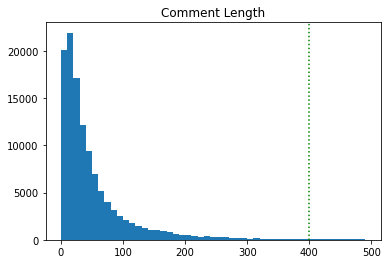

In [37]:
plt.hist(comments,bins = np.arange(0,500,10))
plt.axvline(x=400, color='g', ls=':')
plt.title('Comment Length')
plt.show()


In [38]:
#Average comment block is ~ 30 will capture the majority with 400

In [40]:
maxlen = 400
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [41]:
X_t.shape[1]

400

In [42]:
type(X_t)

numpy.ndarray

### Vanilla Neural Network: Keras 

In [43]:
import random

In [44]:
random.seed(0)

In [45]:
van_model = Sequential()

In [46]:
van_model.add(Dense(10, activation='relu', input_shape=(X_t.shape[1],) ))
van_model.add(Dense(6, activation='sigmoid'))

In [47]:
van_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
van_history = van_model.fit(X_t, y_train, epochs=10,
                            batch_size=200,
                            validation_split=.2)

Train on 95742 samples, validate on 23936 samples
Epoch 1/10
95742/95742 [==============================] - 1s 14us/step - loss: 0.6064 - accuracy: 0.9595 - val_loss: 0.2156 - val_accuracy: 0.9642
Epoch 2/10
95742/95742 [==============================] - 1s 15us/step - loss: 0.2209 - accuracy: 0.9621 - val_loss: 0.2035 - val_accuracy: 0.9642
Epoch 3/10
95742/95742 [==============================] - 2s 16us/step - loss: 0.2039 - accuracy: 0.9622 - val_loss: 0.2001 - val_accuracy: 0.9642
Epoch 4/10
95742/95742 [==============================] - 1s 15us/step - loss: 0.1945 - accuracy: 0.9630 - val_loss: 0.1934 - val_accuracy: 0.9643
Epoch 5/10
95742/95742 [==============================] - 1s 15us/step - loss: 0.1913 - accuracy: 0.9629 - val_loss: 0.1897 - val_accuracy: 0.9642
Epoch 6/10
95742/95742 [==============================] - 2s 16us/step - loss: 0.1894 - accuracy: 0.9628 - val_loss: 0.1922 - val_accuracy: 0.9643
Epoch 7/10
95742/95742 [==============================] - 2s 17us/st

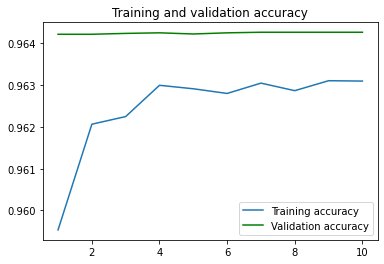

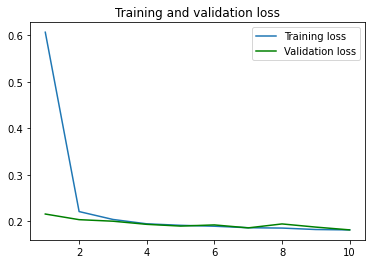

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = van_history.history['accuracy']
val_acc = van_history.history['val_accuracy']
loss = van_history.history['loss']
val_loss = van_history.history['val_loss']
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, color='g' , label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [50]:
def plot_loss_acc(history):
    import matplotlib.pyplot as plt
    %matplotlib inline 

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) +1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, color='g' , label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    

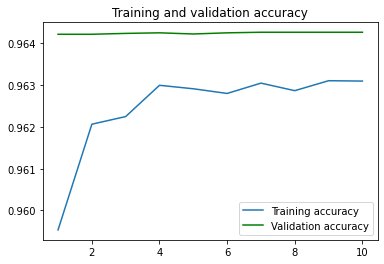

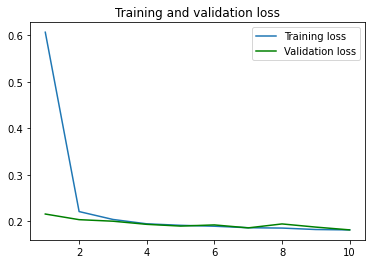

In [51]:
plot_loss_acc(van_history)

#### Vanilla Neural Network Observations:

Initialized a very small and shallow 'vanilla' model to observe convergence trends and behavior.  Zero response from validation data and model overtrains by second epoch.

### RNN: LSTM_60_50_6

Implementing LSTM and dropout to see if there's improvement.

In [52]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=3), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [53]:
rnn = Sequential()
embedding_size = 128

rnn.add(Embedding(max_features, embedding_size, input_length=X_t.shape[1] ))
#adding LSTM layer to help 'forget' then pooling
rnn.add(LSTM(60, return_sequences

In [54]:
rnn.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
            

In [55]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 128)          256000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 400, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

In [56]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=3), 
                  ModelCheckpoint(filepath='best_model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True)]

In [57]:
## WARNING ⏰ 50 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history = rnn.fit(X_t, y_train, epochs=10, 
                  callbacks=early_stopping,
                  batch_size=200, validation_split=0.2)
timer = timer.stop()

[i] Timer started at06/09/20 - 08:12 PM


C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 95742 samples, validate on 23936 samples
Epoch 1/10
95742/95742 [==============================] - 654s 7ms/step - loss: 0.1612 - accuracy: 0.9570 - val_loss: 0.1206 - val_accuracy: 0.9643
Epoch 2/10
95742/95742 [==============================] - 599s 6ms/step - loss: 0.0771 - accuracy: 0.9745 - val_loss: 0.0591 - val_accuracy: 0.9798
Epoch 3/10
95742/95742 [==============================] - 599s 6ms/step - loss: 0.0581 - accuracy: 0.9803 - val_loss: 0.0545 - val_accuracy: 0.9813
Epoch 4/10
95742/95742 [==============================] - 597s 6ms/step - loss: 0.0553 - accuracy: 0.9809 - val_loss: 0.0545 - val_accuracy: 0.9812
Epoch 5/10
95742/95742 [==============================] - 602s 6ms/step - loss: 0.0535 - accuracy: 0.9814 - val_loss: 0.0541 - val_accuracy: 0.9814
Epoch 6/10
95742/95742 [==============================] - 609s 6ms/step - loss: 0.0518 - accuracy: 0.9817 - val_loss: 0.0537 - val_accuracy: 0.9815
Epoch 7/10
95742/95742 [==============================] - 606s

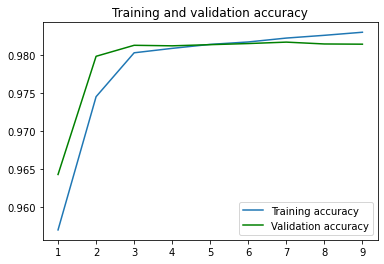

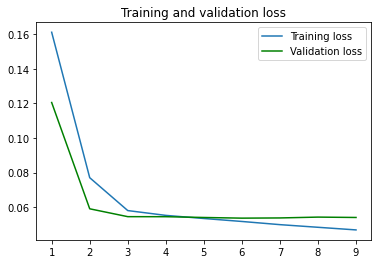

In [58]:
plot_loss_acc(history)

In [59]:
y_h_train_probs = rnn.predict(X_t)

In [60]:
y_hat_test_proba = rnn.predict(X_te)
y_hat_test_proba[1]

array([3.3951402e-03, 5.7173984e-06, 7.9324841e-04, 8.3418363e-06,
       6.1541796e-04, 4.9388807e-05], dtype=float32)

In [61]:
y_preds = pd.DataFrame(np.round(y_hat_test_proba), columns=target_classes)

In [62]:
y_preds_train = pd.DataFrame(np.round(y_h_train_probs), columns=target_classes)

In [63]:
y_preds

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
39888,0.0,0.0,0.0,0.0,0.0,0.0
39889,0.0,0.0,0.0,0.0,0.0,0.0
39890,0.0,0.0,0.0,0.0,0.0,0.0
39891,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
y_preds.shape

(39893, 6)

In [65]:
y_test.shape

(39893, 6)

In [66]:
val_counts_y_preds = y_preds.apply(pd.Series.value_counts)
val_counts

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,108235,118494,113318,119322,113760,118613
1,11443,1184,6360,356,5918,1065


In [68]:
type(y_preds)


pandas.core.frame.DataFrame

In [69]:
type(y_test)

pandas.core.frame.DataFrame

In [70]:
y_train.shape[1]

6

In [71]:
from sklearn.metrics import classification_report, confusion_matrix

Training Data Outcomes:

In [74]:
for i in range(0,y_train.shape[1]):
    y_i_hat_t = y_preds_train.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_hat_t, y_i_t))

toxic
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    110118
         1.0       0.73      0.88      0.80      9560

    accuracy                           0.96    119678
   macro avg       0.86      0.93      0.89    119678
weighted avg       0.97      0.96      0.97    119678

severe_toxic
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    118977
         1.0       0.35      0.59      0.44       701

    accuracy                           0.99    119678
   macro avg       0.67      0.79      0.72    119678
weighted avg       0.99      0.99      0.99    119678

obscene
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    113594
         1.0       0.81      0.85      0.83      6084

    accuracy                           0.98    119678
   macro avg       0.90      0.92      0.91    119678
weighted avg       0.98      0.98      0.98    

In [75]:
for i in range(0,y_train.shape[1]):
    y_i_hat = y_preds.iloc[:,i]
    y_i = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i, y_i_hat))

toxic
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     36042
           1       0.82      0.67      0.74      3851

    accuracy                           0.95     39893
   macro avg       0.89      0.83      0.86     39893
weighted avg       0.95      0.95      0.95     39893

severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39482
           1       0.51      0.30      0.37       411

    accuracy                           0.99     39893
   macro avg       0.75      0.65      0.68     39893
weighted avg       0.99      0.99      0.99     39893

obscene
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     37804
           1       0.82      0.78      0.80      2089

    accuracy                           0.98     39893
   macro avg       0.90      0.89      0.89     39893
weighted avg       0.98      0.98      0.98    

C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39553
           1       0.62      0.01      0.03       340

    accuracy                           0.99     39893
   macro avg       0.81      0.51      0.51     39893
weighted avg       0.99      0.99      0.99     39893



In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


def calc_loss(y_true, y_pred):
    return np.mean([log_loss(y_true[:, i], y_pred[:, i]) 
                    for i in range(y_true.shape[1])])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_test.head()

In [ ]:
y_test[]

In [ ]:
confusion_matrix(y_hat_test.round(),y_test, normalize=False)

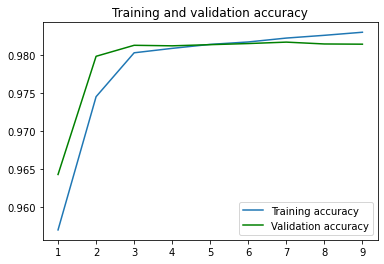

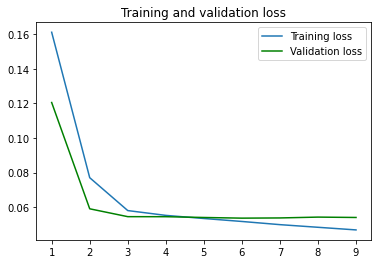

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, color='g' , label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### RNN_LSTM_tiny_25_20_6

In [81]:
rnn_tiny = Sequential()
embedding_size = 128

rnn_tiny.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_tiny.add(LSTM(25, return_sequences=True,name='lstm_layer'))        
rnn_tiny.add(GlobalMaxPool1D())
rnn_tiny.add(Dropout(0.1))  
rnn_tiny.add(Dense(20, activation='relu',kernel_regularizer=regularizers.l2(.0001) ))
rnn_tiny.add(Dropout(0.1))
rnn_tiny.add(Dense(6, activation='sigmoid'))

In [106]:
rnn_tiny.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [107]:
## WARNING ⏰ 45 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_tiny_rnn = rnn_tiny.fit(X_t, y_train, epochs=20, 
                       batch_size=200, 
                       callbacks=early_stopping,
                       validation_split=0.2)
timer = timer.stop()

[i] Timer started at06/10/20 - 06:31 AM


C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 95742 samples, validate on 23936 samples
Epoch 1/20
95742/95742 [==============================] - 229s 2ms/step - loss: 0.1970 - accuracy: 0.9428 - val_loss: 0.1113 - val_accuracy: 0.9643
Epoch 2/20
95742/95742 [==============================] - 253s 3ms/step - loss: 0.0818 - accuracy: 0.9728 - val_loss: 0.0608 - val_accuracy: 0.9796
Epoch 3/20
95742/95742 [==============================] - 265s 3ms/step - loss: 0.0637 - accuracy: 0.9792 - val_loss: 0.0584 - val_accuracy: 0.9808
Epoch 4/20
95742/95742 [==============================] - 270s 3ms/step - loss: 0.0610 - accuracy: 0.9799 - val_loss: 0.0578 - val_accuracy: 0.9808
Epoch 5/20
95742/95742 [==============================] - 266s 3ms/step - loss: 0.0593 - accuracy: 0.9803 - val_loss: 0.0578 - val_accuracy: 0.9809
Epoch 6/20
95742/95742 [==============================] - 266s 3ms/step - loss: 0.0576 - accuracy: 0.9805 - val_loss: 0.0575 - val_accuracy: 0.9810
Epoch 7/20
95742/95742 [==============================] - 269s

In [108]:
# list all data in history
print(history_tiny_rnn.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


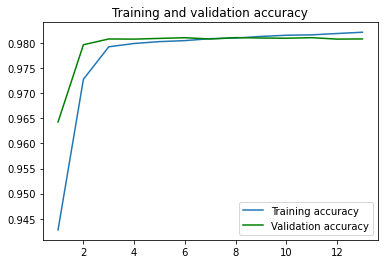

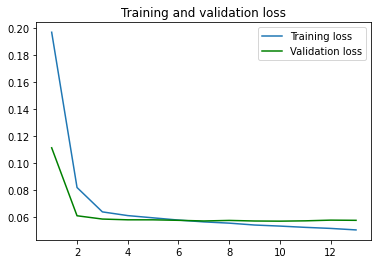

In [109]:
plot_loss_acc(history_tiny_rnn)

In [110]:
y_hat_test_proba_trnn = rnn.predict(X_te)
y_hat_test_proba_trnn[1]

array([3.3951402e-03, 5.7173984e-06, 7.9324841e-04, 8.3418363e-06,
       6.1541796e-04, 4.9388807e-05], dtype=float32)

In [112]:
for i in range(0,y_train.shape[1]):
    y_i_hat_trnn = y_preds.iloc[:,i]
    y_i_trnn = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_trnn, y_i_hat_trnn))

toxic
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     36042
           1       0.82      0.67      0.74      3851

    accuracy                           0.95     39893
   macro avg       0.89      0.83      0.86     39893
weighted avg       0.95      0.95      0.95     39893

severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39482
           1       0.51      0.30      0.37       411

    accuracy                           0.99     39893
   macro avg       0.75      0.65      0.68     39893
weighted avg       0.99      0.99      0.99     39893

obscene
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     37804
           1       0.82      0.78      0.80      2089

    accuracy                           0.98     39893
   macro avg       0.90      0.89      0.89     39893
weighted avg       0.98      0.98      0.98    

C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RNN_60_25_6

In [113]:
from tensorflow.keras import regularizers

In [114]:
rnn_small = Sequential()
embedding_size = 128

rnn_small.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_small.add(LSTM(20, return_sequences=True,name='lstm_layer'))        
rnn_small.add(GlobalMaxPool1D())
rnn_small.add(Dropout(0.1))  
rnn_small.add(Dense(10, kernel_regularizer=regularizers.l2(.0001),activation='relu'))
rnn_small.add(Dropout(0.1))
rnn_small.add(Dense(6, activation='sigmoid'))

In [ ]:
import keras

In [115]:
rnn_small.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [116]:
## WARNING ⏰ 30 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history = rnn_small.fit(X_t, y_train, epochs=20, batch_size=300, 
                        callbacks=early_stopping, validation_split=0.2)
timer = timer.stop()

[i] Timer started at06/10/20 - 08:51 AM
Train on 95742 samples, validate on 23936 samples
Epoch 1/20
95742/95742 [==============================] - 258s 3ms/step - loss: 0.2196 - accuracy: 0.9546 - val_loss: 0.1119 - val_accuracy: 0.9642
Epoch 2/20
95742/95742 [==============================] - 266s 3ms/step - loss: 0.0958 - accuracy: 0.9632 - val_loss: 0.0782 - val_accuracy: 0.9651
Epoch 3/20
95742/95742 [==============================] - 227s 2ms/step - loss: 0.0789 - accuracy: 0.9685 - val_loss: 0.0689 - val_accuracy: 0.9723
Epoch 4/20
95742/95742 [==============================] - 246s 3ms/step - loss: 0.0715 - accuracy: 0.9744 - val_loss: 0.0652 - val_accuracy: 0.9773
Epoch 5/20
95742/95742 [==============================] - 279s 3ms/step - loss: 0.0658 - accuracy: 0.9783 - val_loss: 0.0591 - val_accuracy: 0.9808
Epoch 6/20
95742/95742 [==============================] - 284s 3ms/step - loss: 0.0603 - accuracy: 0.9798 - val_loss: 0.0575 - val_accuracy: 0.9810
Epoch 7/20
95742/95742

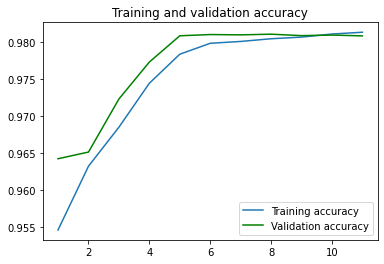

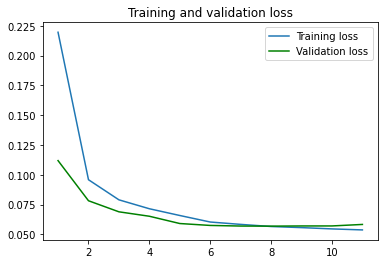

In [117]:
plot_loss_acc(history)

In [121]:
for i in range(0,y_train.shape[1]):
    y_i_hat_t = y_preds_train.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
    print(confusion_matrix(y_i_hat_t, y_i_t))
    

toxic


TypeError: 'DataFrame' object is not callable

In [122]:
for i in range(0,y_train.shape[1]):
    y_i_hat_t = y_preds_train.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_hat_t, y_i_t))

toxic
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    110118
         1.0       0.73      0.88      0.80      9560

    accuracy                           0.96    119678
   macro avg       0.86      0.93      0.89    119678
weighted avg       0.97      0.96      0.97    119678

severe_toxic
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    118977
         1.0       0.35      0.59      0.44       701

    accuracy                           0.99    119678
   macro avg       0.67      0.79      0.72    119678
weighted avg       0.99      0.99      0.99    119678

obscene
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    113594
         1.0       0.81      0.85      0.83      6084

    accuracy                           0.98    119678
   macro avg       0.90      0.92      0.91    119678
weighted avg       0.98      0.98      0.98    

#### Evaluation of RNN_60_25_6

In [ ]:
stop

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params_to_test = {'n_units':[(50,25,7),(100,50,7)],
                  'optimizer':['adam','rmsprop','adadelta'],
                  'activation':['linear','relu','tanh'],
                  'final_activation':['softmax']}


In [ ]:
van_model = Sequential()

In [ ]:
van_model.add(Dense(50, activation='relu', input_shape=n_features, ))
van_model.add(Dense(6, activation='softmax'))

In [ ]:
van_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])


In [ ]:
# ⏰ This cell may take several minutes to run
batch_size = 

timer = fn.Timer()
timer.start()
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
timer.stop()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y_train.shape

In [ ]:
van_model.fit(tf_idf_data_train, y_train, 
             validation_data=X_val, y_val)

In [ ]:
import importlib
importlib.reload(fn)


In [ ]:
y_train.shape

## Conclusion:

## Appendix:

In [123]:
#! pip install wordcloud
import matplotlib.pyplot as plt

(-0.5, 399.5, 199.5, -0.5)

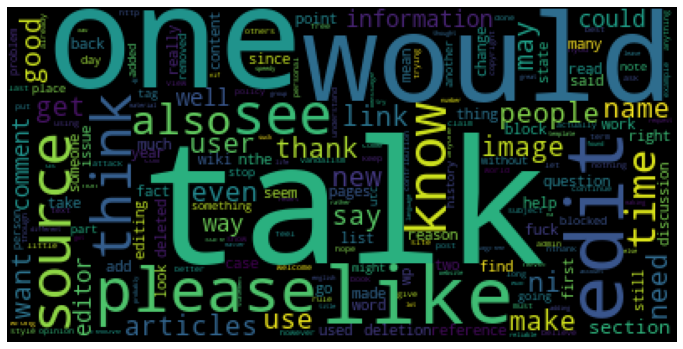

In [124]:
import wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(stopped_tokens))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

examples of each kind of comment:

In [148]:
print("toxic:")
print(train[train['toxic']==1].iloc[2,1])

toxic:
Bye! 

Don't look, come or think of comming back! Tosser.


In [136]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [135]:
print("severe toxic:")
print(train[train['severe_toxic']==1].iloc[4,1])

severe toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [130]:
#wordcloud for stopped columns: 
for comment in range(0,y_train.shape[1]):
    subset=y_train[y_train[comment]==1]
    text= train[comment].values
    wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords_list)
    wc.generate(" ".join(stopped_tokens))
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.title(f"Words frequented in {comment_class} Comments", fontsize=20)
    plt.imshow(wordcloud) 


KeyError: 0

In [ ]:
y_train.head()

In [ ]:


#wordcloud for clean comments
subset=y_train[y_train['severe_toxic']==1]
text= train['comment_text'].values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords_list)
wc.generate(" ".join(stopped_tokens))
plt.figure(figsize=(12,12))
plt.axis('off')
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wordcloud) 

In [ ]:

wordcloud_tox = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(stopped_tokens))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

In [ ]:
import seaborn as sns


In [ ]:
train.head()

In [ ]:
print("toxic:")
print(train[train['toxic']==1].iloc[3,1])

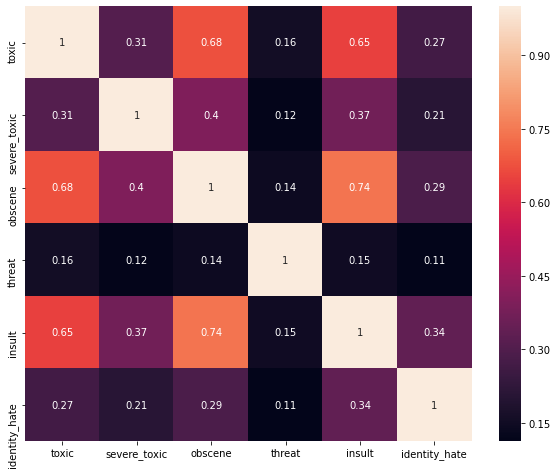

In [119]:
corr=y_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [ ]:
 def highlight_max(x):
        return ['background-color: yellow' if v == x.max() else ''
                for v in x]

In [ ]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, 
# look in comparison with other tags
main_col="toxic"
corr_mats=[]
for other_col in y_train.columns:
    confusion_matrix = pd.crosstab(y_train[main_col], y_train[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=y_train)

#cell highlighting
out = out.style.apply(highlight_max,axis=0)
out

In [ ]:
#Checking for Toxic and Severe toxic for now
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

In [ ]:
##functions to improve eda

In [ ]:
# from ipywidgets import interact

# @interact
# def process_text(i=(0,len(text[:1]))):
    
    
#     print(f"- Comment #{i}), text[:1]}:\n")
    
#     lemmatizer = WordNetLemmatizer()
#     text = lemmatizer.lemmatize(text)
    
#     tokens = nltk.word_tokenize(text)
    
#     stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    
#     print(tokens,end='\n\n')
#     print(stopped_tokens)

In [ ]:
# from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


# def calc_loss(y_true, y_pred):
#     return np.mean([log_loss(y_true[:, i], y_pred[:, i]) 
#                     for i in range(y_true.shape[1])])